In [ ]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [ ]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
df = pd.read_csv('RILO.csv',sep=',', index_col='Date', parse_dates=['Date'], date_parser=dateparse).fillna(0)
df

,Symbol,Series,Prev Close,Open Price,High Price,Low Price,Last Price,Close Price,Average Price,Total Traded Quantity,Turnover,No. of Trades,Deliverable Qty,% Dly Qt to Traded Qty
Date,,,,,,,,,,,,,,
2016-01-01,RELIANCE,EQ,1014.60,1009.80,1018.9,1008.20,1013.6,1015.35,1015.52,1238135,1.257353e+09,30701,529539,42.77
2016-01-04,RELIANCE,EQ,1015.35,1005.00,1013.8,986.70,993.2,995.30,998.91,6896571,6.889070e+09,66235,4974602,72.13
2016-01-05,RELIANCE,EQ,995.30,1000.30,1010.0,997.00,1005.0,1005.15,1003.41,3416459,3.428125e+09,59935,1987804,58.18
2016-01-06,RELIANCE,EQ,1005.15,1007.60,1038.4,1000.40,1029.1,1032.20,1028.15,6116855,6.289073e+09,160947,2912662,47.62
2016-01-07,RELIANCE,EQ,1032.20,1021.05,1028.0,1008.05,1018.9,1013.25,1016.73,4512219,4.587700e+09,105075,2474491,54.84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-30,RELIANCE,EQ,2024.05,2008.50,2036.0,1987.55,1995.9,1994.50,2010.20,9150974,1.839532e+10,288687,3902504,42.65
2021-05-03,RELIANCE,EQ,1994.50,1966.00,1979.0,1943.10,1956.0,1959.05,1958.46,10909942,2.136664e+10,343806,3800598,34.84
2021-05-04,RELIANCE,EQ,1959.05,1950.00,1967.8,1911.00,1918.0,1916.60,1935.83,10083693,1.952033e+10,325798,4435071,43.98


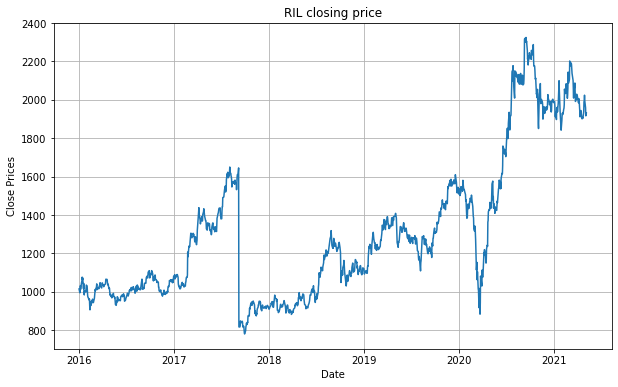

In [ ]:
#plot close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(df['Close Price'])
plt.title('RIL closing price')
plt.show()

<AxesSubplot:ylabel='Density'>

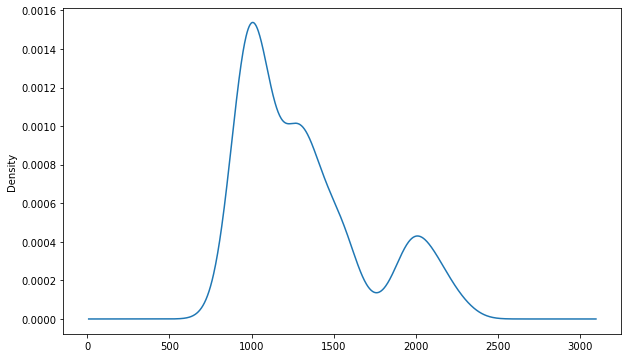

In [ ]:
#Distribution of the dataset
df_close = df['Close Price']
df_close.plot(kind='kde')

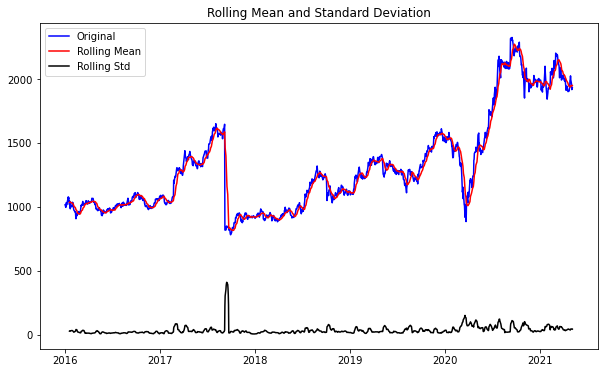

Results of dickey fuller test
Test Statistics                  -1.351750
p-value                           0.605177
No. of lags used                  0.000000
Number of observations used    1323.000000
critical value (1%)              -3.435302
critical value (5%)              -2.863727
critical value (10%)             -2.567934
dtype: float64


In [ ]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
test_stationarity(df_close)

<Figure size 720x432 with 0 Axes>

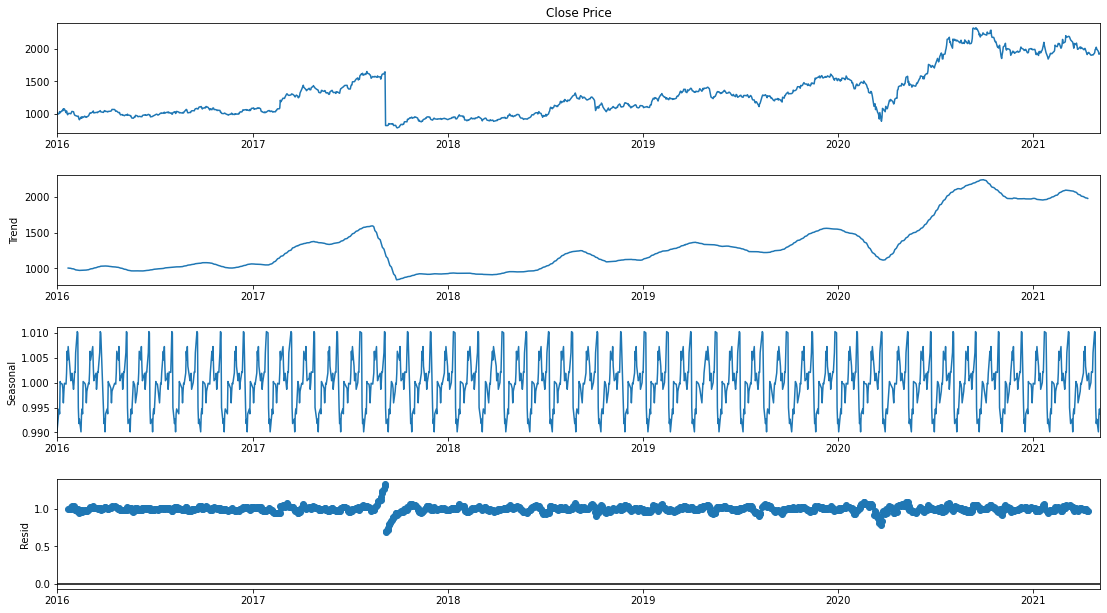

In [ ]:
#To separate the trend and the seasonality from a time series, 
# we can decompose the series using the following code.
result = seasonal_decompose(df_close, model='multiplicative', freq = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

No handles with labels found to put in legend.


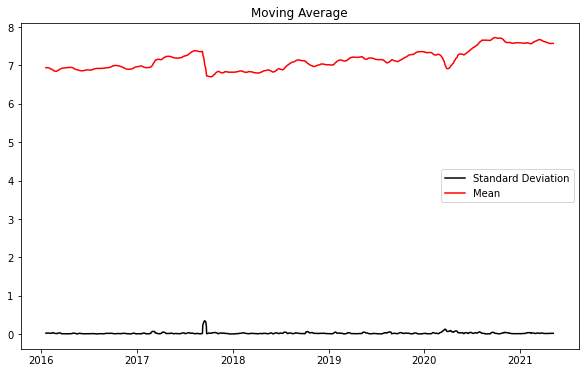

In [ ]:
#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

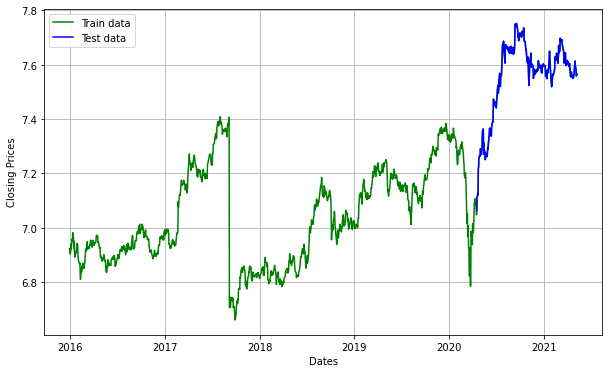

In [ ]:
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.8)], df_log[int(len(df_log)*0.8):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4505.094, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4503.953, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4503.913, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4507.080, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4502.108, Time=0.33 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.810 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1056
Model:               SARIMAX(0, 1, 0)   Log Likelihood                2254.540
Date:                Tue, 09 Nov 2021   AIC                          -4507.080
Time:                        20:53:25   BIC                          -4502.119
Sample:                             0   HQIC                         -4505.199
                               - 1056                                  

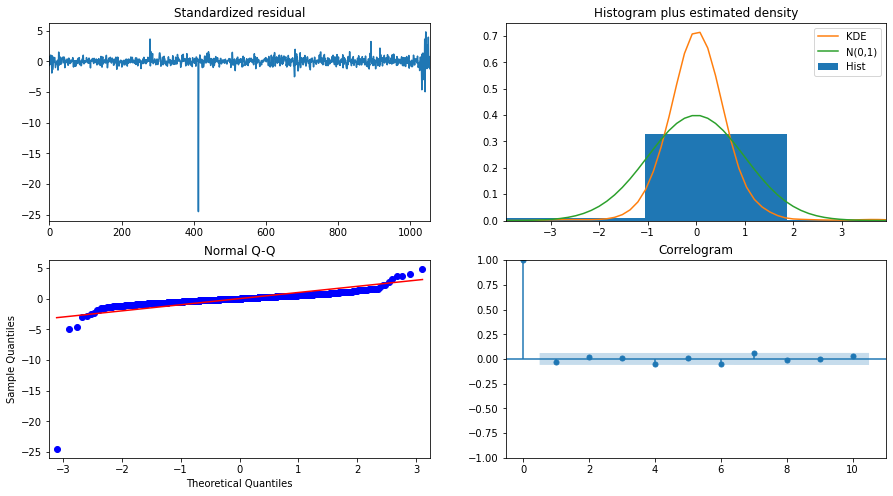

In [ ]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [ ]:
#Modeling
# Build Model
model = ARIMA(train_data, order=(1,1,2))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

                             ARIMA Model Results                              
Dep. Variable:          D.Close Price   No. Observations:                 1055
Model:                 ARIMA(1, 1, 2)   Log Likelihood                2255.334
Method:                       css-mle   S.D. of innovations              0.029
Date:                Tue, 09 Nov 2021   AIC                          -4500.667
Time:                        20:53:26   BIC                          -4475.861
Sample:                             1   HQIC                         -4491.264
                                                                              
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0001      0.001      0.116      0.908      -0.002       0.002
ar.L1.D.Close Price     0.0339      0.506      0.067      0.947      -0.958       1.025
ma.L1.D.Close Pr

In [ ]:
# Forecast
fc, se, conf = fitted.forecast(265, alpha=0.075)  # 95% conf

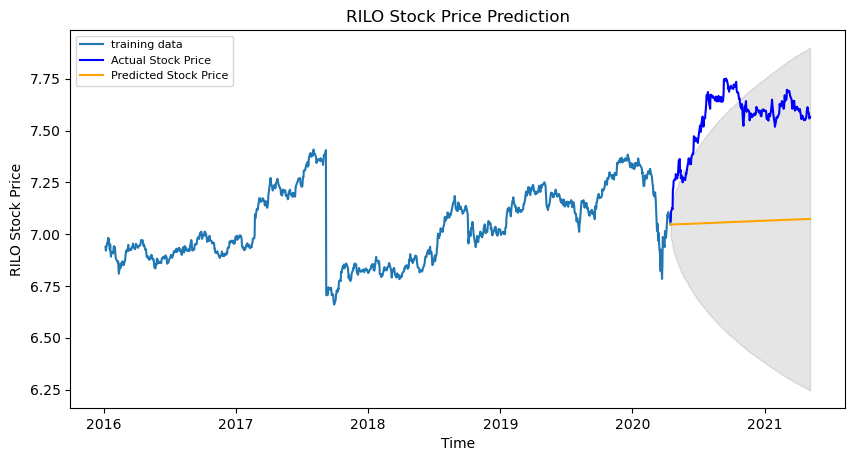

In [ ]:
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training data')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('RILO Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('RILO Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
# report performance
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

MSE: 0.2666118751184002
MAE: 0.4989445218350714
RMSE: 0.5163447250804448
MAPE: 0.06570097933530679


In [ ]:
print(fc_series)

Date
2020-10-22    7.047780
2020-10-23    7.046871
2020-10-26    7.046939
2020-10-27    7.047040
2020-10-28    7.047141
                ...   
2021-04-30    7.059783
2021-05-03    7.059885
2021-05-04    7.059987
2021-05-05    7.060089
2021-05-06    7.060191
Length: 133, dtype: float64


In [ ]:
#Getting the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions- y_test)**2)))
rmse